# Samsung AI Challenge for Scientific Discovery 
dacon: https://dacon.io/competitions/official/235789/overview/description  
Reference of code: https://github.com/SeungsuKim/CH485--AI-and-Chemistry/tree/master/Assignments/5.%20GCN

## 01. Install and Load required packages 
- install: rdkit, Mordred

In [ ]:
# install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
  install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.11
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
# install mordred
!pip install mordred

     |████████████████████████████████| 128 kB 4.2 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=5f89e8813d2f5d0e72f4d9c574e5d3bb37699a7fbd3adb1806495ca0e5adb85e
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import sys
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import argparse
import warnings; warnings.filterwarnings("ignore")
from tqdm import tnrange, tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.metrics import mean_absolute_error

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from mordred import Calculator, descriptors

In [ ]:
MY_PATH = '/content/drive/MyDrive/Colab_Notebooks/dacon/'
DATA_DIR = MY_PATH + 'data/'
SUBMISSION_DIR = MY_PATH + 'submission/'
CLEANED_DIR = MY_PATH + 'cleaned/'
MODEL_DIR = MY_PATH + 'model/'

In [ ]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [ ]:

np.random.seed(args.seed)
torch.manual_seed(args.seed)

## 02. Data Pre-processing

In [ ]:
# extract datasets
my_zip = zipfile.ZipFile(DATA_DIR + "Samsung AI Challenge for Scientific Discovery_data.zip")
if not (os.path.isdir('./dataset')):
  os.makedirs(os.path.join('dataset'))
my_zip.extractall('dataset')
my_zip.close()

In [ ]:
train_original = pd.read_csv('dataset/train.csv')
dev = pd.read_csv('dataset/dev.csv')
test = pd.read_csv('dataset/test.csv')

submission = pd.read_csv('dataset/sample_submission.csv')

In [ ]:
train = train_original # pd.concat([train_original, dev], axis=0)

train_original.shape, train.shape, dev.shape, test.shape

((30274, 4), (30274, 4), (71, 4), (602, 2))

In [ ]:
def read_ZINC_smiles(dataframe):
    smi_list = list(train['SMILES'].str.strip())
    s1_list = np.array(train['S1_energy(eV)'])
    t1_list = np.array(train['T1_energy(eV)'])

    return smi_list, s1_list, t1_list

In [ ]:
list_smi, list_s1, list_t1 = read_ZINC_smiles(train)

In [ ]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_feature(atom):
  # feature matrix 생성
  return np.array(
                  # one_of_k_encoding_unk(atom.GetSymbol(),
                  #                     ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                  #                      'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                  #                      'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                  #                      'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) + # 40개 원자
                  one_of_k_encoding_unk(atom.GetSymbol(), # ['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si']
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'I', 'B']) + # 12개 원자
                  one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6]) + # 7개 output
                  one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) + # 5개 output
                  one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) + # 6개 output
                  # 여기서부터 내가 추가
                  one_of_k_encoding(atom.GetNumImplicitHs(), [0, 1, 2, 3, 4]) + # 4개 output
                  one_of_k_encoding(atom.GetNumExplicitHs(), [0, 1, 2, 3]) + # 4개 output
                  one_of_k_encoding(atom.GetChiralTag().bit_length(), [0, 1, 2]) + # 3개 output
                  one_of_k_encoding(atom.GetFormalCharge()+1, [0, 1, 2]) + # 3개 output
                  one_of_k_encoding(atom.GetHybridization().conjugate()-1, [0, 1, 2, 3, 4, 5]) + # 3개 output
                  one_of_k_encoding(int(atom.GetNoImplicit()), [0, 1]) + # 2개 output
                  
                  [atom.GetIsAromatic()]) # 1개 output   
                  # 총 40 + 7 + 5 + 6 + 1 = 59개 (원래는)
                  # 총 12 + 7 + 5 + 6 + 4 + 3 + 3 + 3 + 3 + 2 = 49

In [ ]:
def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 100  # Number of atoms used: quantile 90% 65개
    for i in smiles_list:
        # Mol matrix
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj matrix
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 54))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:54] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj

In [ ]:
list_feature, list_adj = convert_to_graph(list_smi)

In [ ]:
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_s1_t1):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_s1_t1 = list_s1_t1

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_s1_t1[index]


def partition(list_feature, list_adj, list_s1_t1, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    # train
    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    s1_t1_train = list_s1_t1[:num_train]

    # val
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    s1_t1_val = list_s1_t1[num_train:num_train + num_val]

    # test
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    s1_t1_test = list_s1_t1[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, s1_t1_train)
    val_set = GCNDataset(feature_val, adj_val, s1_t1_val)
    test_set = GCNDataset(feature_test, adj_test, s1_t1_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [ ]:
dict_partition_s1 = partition(list_feature, list_adj, list_s1, args)
dict_partition_t1 = partition(list_feature, list_adj, list_t1, args)

## 03. Model

In [ ]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.activation = act
        
    def forward(self, x, adj):
        out = self.linear(x)
        out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        return out, adj

In [ ]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [ ]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [ ]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [ ]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [ ]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [ ]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.sc))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

## 04. Training and Validation

In [ ]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_s1_t1 = torch.tensor(batch[2]).to(device).float()
        list_s1_t1 = list_s1_t1.view(-1,1)
                
        model.train()
        optimizer.zero_grad()
        list_pred_s1_t1 = model(list_feature, list_adj)
        list_pred_s1_t1.require_grad = False
        train_loss = criterion(list_pred_s1_t1, list_s1_t1)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [ ]:
train_original.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [ ]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_s1_t1 = torch.tensor(batch[2]).to(device).float()
            list_s1_t1 = list_s1_t1.view(-1,1)

            model.eval()
            list_pred_s1_t1 = model(list_feature, list_adj)
            list_pred_s1_t1.require_grad = False
            val_loss = criterion(list_pred_s1_t1, list_s1_t1)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [ ]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        s1_t1_total = list()
        pred_s1_t1_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_s1_t1 = torch.tensor(batch[2]).to(device).float()
            s1_t1_total += list_s1_t1.tolist()
            list_s1_t1 = list_s1_t1.view(-1,1)

            list_pred_s1_t1 = model(list_feature, list_adj)
            pred_s1_t1_total += list_pred_s1_t1.view(-1).tolist()

        mae = mean_absolute_error(s1_t1_total, pred_s1_t1_total)
        std = np.std(np.array(s1_t1_total)-np.array(pred_s1_t1_total))
        
    return mae, std, s1_t1_total, pred_s1_t1_total

In [ ]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GCNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, s1_t1_total, pred_s1_t1_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.s1_t1_total = s1_t1_total
    args.pred_s1_t1_total = pred_s1_t1_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

In [ ]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)

In [ ]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [ ]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [ ]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 's1_t1_total', 'pred_s1_t1_total')
    g.map(identity, 's1_t1_total', 's1_t1_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

In [ ]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 1
args.n_atom = 100
args.in_dim = 54
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition_s1['train'])+len(dict_partition_s1['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition_s1, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')

  0%|          | 0/2721900 [00:00<?, ?it/s]

MAE: 0.7286984783
Std: 0.9790365338


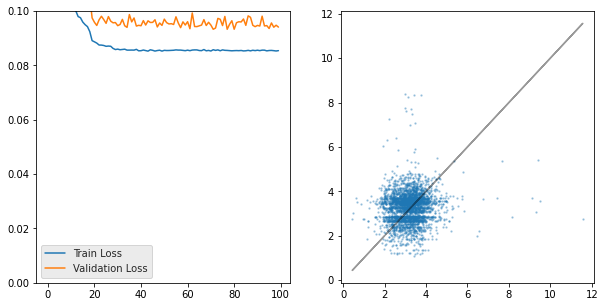

In [ ]:
df_result = pd.read_json('result 190000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 0.1])
ax[0].legend()
ax[1].scatter(df_result['s1_t1_total'][0], df_result['pred_s1_t1_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['s1_t1_total'][0], df_result['s1_t1_total'][0], color='black', alpha=0.4)

In [ ]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

------------

In [ ]:
!curl -o ZINC.smiles https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/ZINC.smiles
!curl -o vocab.npy https://raw.githubusercontent.com/heartcored98/Standalone-DeepLearning/master/Lec9/vocab.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5374k  100 5374k    0     0  10.4M      0 --:--:-- --:--:-- --:--:-- 10.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256  100   256    0     0   1662      0 --:--:-- --:--:-- --:--:--  1662


In [ ]:
from rdkit.Chem.Crippen import MolLogP

In [ ]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in range(num_mol):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list

list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 10000)

In [ ]:
def atom_feature(atom):
  # feature matrix 생성
  return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) + # 40개 원자
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) + # 6개 output
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) + # 5개 output
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) + # 6개 output
                    [atom.GetIsAromatic()] # 1개 output)    
                    # 총 40 + 6 + 5 + 6 + 1 = 58개

In [ ]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [ ]:
def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in smiles_list:
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj

In [ ]:
t = convert_to_graph(list_smi)

In [ ]:
temp = list_smi[0]
temp2 = Chem.MolFromSmiles(temp)
temp3 = Chem.rdmolops.GetAdjacencyMatrix(temp2)

In [ ]:
temp3.shape

(28, 28)

In [ ]:
t[0].shape

(10000, 50, 58)

In [ ]:
print(len(t[0]))
print(len(t[1]))
t[1][0].shape

10000
10000


(50, 50)

In [ ]:
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [ ]:
dict_partition = partition(list_feature, list_adj, list_logP, args)

---------------

In [ ]:
calc = Calculator(descriptors, ignore_3D=False)
len(calc.descriptors)

In [ ]:
x_train = calc.pandas([Chem.MolFromSmiles(x) for x in train.SMILES])
x_train

In [ ]:
train_complete = pd.concat([train, x_train], axis=1)
train_complete

In [ ]:
x_test = calc.pandas([Chem.MolFromSmiles(x) for x in test.SMILES])
x_test

In [ ]:
test_complete = pd.concat([test, x_test], axis=1)
test_complete